In [1]:
import os
import torch
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from tqdm import trange
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
class CNN1D(nn.Module):
    def __init__(self, number_of_categories):
        super(CNN1D, self).__init__()
        # convolution layer
        # in_channels must be the same as the number of subcarriers, out_channels can be any value
        self.conv1d = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, stride=1)
        self.conv1d_2 = nn.Conv1d(in_channels=64, out_channels=40, kernel_size=5, stride=1)
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        self.relu = nn.ReLU()

        # calculate the in_features
        self.fc1 = nn.Linear(in_features=40 * 7, out_features=128)
        # self.fc1 = nn.Linear(in_features=120, out_features=90)
        #self.fc1 = nn.Linear(in_features=40 * 19, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=number_of_categories)

    def forward(self, x):
        # input tensor size [batch_size, 64 (features), 40 (sequence length)]
        x = self.conv1d(x)
        # [batch_size, 64 (features), 40 (sequence length)]
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv1d_2(x)
        # [batch_size, 64 (features), 40 (sequence length)]
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(-1, x.shape[1] * x.shape[2])  # Adjust the input size based on the output size after convolutions and pooling
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x

In [3]:
class CSIDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.int)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [4]:
def importData():
    X_train, X_val, X_test, y_train, y_val, y_test = [], [], [], [], [], []
    for i in range(10):
        temp_train = np.load(f'../data/movement_processed_data_denoised_butter/{i}_table_train.npy')
        temp_val = np.load(f'../data/movement_processed_data_denoised_butter/{i}_table_val.npy')
        temp_test = np.load(f'../data/movement_processed_data_denoised_butter/{i}_table_test.npy')
        if i == 0:
            X_train = temp_train
            X_val = temp_val
            X_test = temp_test
            y_train = np.array([[i] for _ in range(X_train.shape[0])])
            y_val = np.array([[i] for _ in range(X_val.shape[0])])
            y_test = np.array([[i] for _ in range(X_test.shape[0])])
        else:
            X_train = np.append(X_train, temp_train, axis=0)
            X_val = np.append(X_val, temp_val, axis=0)
            X_test = np.append(X_test, temp_test, axis=0)
            y_train = np.append(y_train, np.array([[i] for _ in range(temp_train.shape[0])]), axis=0)
            y_val = np.append(y_val, np.array([[i] for _ in range(temp_val.shape[0])]), axis=0)
            y_test = np.append(y_test, np.array([[i] for _ in range(temp_test.shape[0])]), axis=0)
            
    return X_train, X_val, X_test, y_train, y_val, y_test

In [5]:
class RunningAverage:
    def __init__(self):
        self.steps = 0
        self.total = 0

    def update(self, val):
        self.total += val
        self.steps += 1

    def __call__(self):
        return self.total / float(self.steps)

def accuracy(outputs, labels):
    # outputs (predicted), labels (true)
    outputs = np.argmax(outputs.cpu().detach().numpy(), axis=1)
    labels = labels.squeeze()
    # compare outputs with labels
    return np.sum([1 if first == second else 0 for first, second in zip(labels, outputs)]) / float(len(labels))

In [6]:
def train(model, optimizer, trainLoader, loss_fn, iterations):
    model.train()
    train_loss = RunningAverage()
    train_acc = RunningAverage()
    
    with trange(iterations) as pbar:
        for X_batch, y_batch in trainLoader:
            y_batch = y_batch.type(torch.LongTensor).squeeze(1)
            logits = model(X_batch)
            y_pred = F.log_softmax(logits, dim=1) # use this for accuracy 
            loss = loss_fn(logits, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss.update(loss)
            train_acc.update(accuracy(y_pred, y_batch))
            pbar.update(1)
            
    return train_loss(), train_acc()
    
def eval(model, valLoader, loss_fn):
    model.eval()
    eval_loss = RunningAverage()
    eval_acc = RunningAverage()
    
    with torch.no_grad():
        for X_batch, y_batch in valLoader:
            y_batch = y_batch.type(torch.LongTensor).squeeze(1)
            logits = model(X_batch)
            y_pred = F.log_softmax(logits, dim=1) # use this for accuracy 
            loss = loss_fn(logits, y_batch)
            
            eval_loss.update(loss)
            eval_acc.update(accuracy(y_pred, y_batch))
            
    return eval_loss(), eval_acc()
    
def test(model, testLoader, test_size):
    model.eval()
    for X_batch, y_batch in testLoader:
        y_batch = y_batch.type(torch.LongTensor).squeeze(1)
        logits = model(X_batch)
        y_pred = F.log_softmax(logits, dim=1) # use this for accuracy 
        
    print(f"Overall Accuracy: {accuracy(y_pred, y_batch):.3f}")

    # True positive percentage
    percentages = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
    # outputs (predicted), labels (true)
    outputs = np.argmax(y_pred.cpu().detach().numpy(), axis=1)
    labels = y_batch.squeeze()
    
    for i in range(len(outputs)):
        if outputs[i] == labels[i]:
            percentages[outputs[i]] += 1
    
    # plot the percentages of correct predictions
    y_percent = [(value/(test_size/10))*100 for key, value in percentages.items()]
    x_label = [str(key) for key, _ in percentages.items()]
    
    fig, test = plt.subplots(figsize=(10,6))
    test.bar(x_label, y_percent)
    test.yaxis.set_major_formatter(mtick.PercentFormatter())
    
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Key")
    plt.title("Accuracy (%) per key")
    plt.savefig("percentage_correct_movement_denoised_butter.png")
    plt.show()
    
    cm = confusion_matrix(y_true=labels, y_pred=outputs)
    cm = np.divide(cm, (test_size/10))
    
    plt.figure(figsize=(10,6))
    sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues')
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.savefig("confusion_matrix_movement_denoised_butter.png")
    plt.show()
    
    print(f"Accuracy for each key: {''.join([x + ': ' + str(round(y, 3)) + '% ' for x, y in zip(x_label, y_percent)])}")
    
    print(classification_report(y_true=labels, y_pred=outputs, target_names=x_label))

In [7]:
def train_and_eval(model, epochs, optimizer, trainLoader, valLoader, loss_fn, iterations):
    # for plotting the loss and accuracy
    train_loss_list, train_acc_list, eval_loss_list, eval_acc_list  = [], [], [], []
        
    for epoch in range(epochs):
        train_loss, train_acc = train(model, optimizer, trainLoader, loss_fn, iterations)
        eval_loss, eval_acc = eval(model, valLoader, loss_fn)
        
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        eval_loss_list.append(eval_loss)
        eval_acc_list.append(eval_acc)
        
        print(f"Train: Epoch {epoch}: Loss {train_loss}, Accuracy {train_acc}")
        print(f"Eval: Epoch {epoch}: Loss {eval_loss}, Accuracy {eval_acc}")
        
    return train_loss_list, train_acc_list, eval_loss_list, eval_acc_list
        

In [8]:
def plot_loss_accuracy(train_loss_list, train_acc_list, eval_loss_list, eval_acc_list, epochs):
    x = [i for i in range(1, epochs+1)]
    
    fig, loss = plt.subplots(figsize=(10,6))
    loss.plot(x, [trainLoss.item() for trainLoss in train_loss_list], label="Training Loss")
    loss.plot(x, [evalLoss.item() for evalLoss in eval_loss_list], label="Validation Loss")
    plt.legend()
    plt.ylabel("Average Loss")
    plt.xlabel("Epochs")
    plt.title("Average Loss per epoch")
    plt.savefig("loss_per_epoch_movement_denoised_butter.png")
    
    plt.show()
    
    fig, acc = plt.subplots(figsize=(10,6))
    acc.plot(x, [trainAcc.item() for trainAcc in train_acc_list], label="Training Accuracy")
    acc.plot(x, [evalAcc.item() for evalAcc in eval_acc_list], label="Validation Accuracy")
    plt.legend()
    plt.ylabel("Average Accuracy")
    plt.xlabel("Epochs")
    plt.title("Average Accuracy per epoch")
    plt.savefig("acc_per_epoch_movement_denoised_butter.png")
    plt.show()

In [9]:
def print_model_parameters(model):
    total_parameters = 0
    print(" "*20 + "Model Parameters" + " "*20)
    print("="*57)
    print(f"{'Layer':<25}" + "| Parameters")
    print("="*57)
    for name, param in model.named_parameters():
        temp = 1
        temp_list = []
        if param.requires_grad:
            print(f"{name:<25}", end="")
            for i in param.data.shape:
                temp *= i
                temp_list.append(str(i))
            print(": ", end="")
            if len(temp_list) > 1:
                print(f"{' * '.join(temp_list)}", end="")
                print(" = " + str(temp))
            else:
                print(f"{''.join(temp_list)}")

        total_parameters += temp
        
    print("="*57)
    print(f"{'Total parameters':<25}" + f": {total_parameters}")
    print("="*57)

100%|██████████| 22/22 [00:00<00:00, 91.68it/s]


Train: Epoch 0: Loss 2.32137393951416, Accuracy 0.10369318181818182
Eval: Epoch 0: Loss 2.3160574436187744, Accuracy 0.09375


100%|██████████| 22/22 [00:00<00:00, 96.48it/s]


Train: Epoch 1: Loss 2.309176445007324, Accuracy 0.10196834415584416
Eval: Epoch 1: Loss 2.312433958053589, Accuracy 0.09375


100%|██████████| 22/22 [00:00<00:00, 98.21it/s] 


Train: Epoch 2: Loss 2.3047139644622803, Accuracy 0.10004058441558442
Eval: Epoch 2: Loss 2.311933755874634, Accuracy 0.08928571428571429


100%|██████████| 22/22 [00:00<00:00, 94.01it/s]


Train: Epoch 3: Loss 2.303297996520996, Accuracy 0.11079545454545454
Eval: Epoch 3: Loss 2.30829119682312, Accuracy 0.11607142857142858


100%|██████████| 22/22 [00:00<00:00, 93.62it/s]


Train: Epoch 4: Loss 2.300544261932373, Accuracy 0.1106939935064935
Eval: Epoch 4: Loss 2.3120152950286865, Accuracy 0.078125


100%|██████████| 22/22 [00:00<00:00, 104.27it/s]


Train: Epoch 5: Loss 2.2970457077026367, Accuracy 0.11921672077922078
Eval: Epoch 5: Loss 2.309976816177368, Accuracy 0.09821428571428571


100%|██████████| 22/22 [00:00<00:00, 101.85it/s]


Train: Epoch 6: Loss 2.292937994003296, Accuracy 0.12357954545454546
Eval: Epoch 6: Loss 2.3070104122161865, Accuracy 0.09821428571428571


100%|██████████| 22/22 [00:00<00:00, 99.55it/s]


Train: Epoch 7: Loss 2.2929840087890625, Accuracy 0.12611607142857142
Eval: Epoch 7: Loss 2.318885564804077, Accuracy 0.09821428571428571


100%|██████████| 22/22 [00:00<00:00, 94.42it/s]


Train: Epoch 8: Loss 2.290919303894043, Accuracy 0.1208400974025974
Eval: Epoch 8: Loss 2.316915273666382, Accuracy 0.07366071428571429


100%|██████████| 22/22 [00:00<00:00, 88.00it/s]


Train: Epoch 9: Loss 2.289135694503784, Accuracy 0.13058035714285715
Eval: Epoch 9: Loss 2.3105106353759766, Accuracy 0.078125


100%|██████████| 22/22 [00:00<00:00, 99.10it/s]


Train: Epoch 10: Loss 2.2876505851745605, Accuracy 0.13088474025974026
Eval: Epoch 10: Loss 2.309962034225464, Accuracy 0.10714285714285714


100%|██████████| 22/22 [00:00<00:00, 115.79it/s]


Train: Epoch 11: Loss 2.281094551086426, Accuracy 0.1520900974025974
Eval: Epoch 11: Loss 2.3160996437072754, Accuracy 0.12053571428571429


100%|██████████| 22/22 [00:00<00:00, 103.76it/s]


Train: Epoch 12: Loss 2.2811121940612793, Accuracy 0.13869724025974026
Eval: Epoch 12: Loss 2.3145763874053955, Accuracy 0.09151785714285714


100%|██████████| 22/22 [00:00<00:00, 102.30it/s]


Train: Epoch 13: Loss 2.281867027282715, Accuracy 0.15036525974025974
Eval: Epoch 13: Loss 2.3139865398406982, Accuracy 0.09375


100%|██████████| 22/22 [00:00<00:00, 93.22it/s] 


Train: Epoch 14: Loss 2.2748382091522217, Accuracy 0.15046672077922077
Eval: Epoch 14: Loss 2.3196520805358887, Accuracy 0.10044642857142858


100%|██████████| 22/22 [00:00<00:00, 104.27it/s]


Train: Epoch 15: Loss 2.2748446464538574, Accuracy 0.1382913961038961
Eval: Epoch 15: Loss 2.328233003616333, Accuracy 0.09598214285714286


100%|██████████| 22/22 [00:00<00:00, 99.53it/s] 


Train: Epoch 16: Loss 2.2690694332122803, Accuracy 0.15716314935064934
Eval: Epoch 16: Loss 2.321643829345703, Accuracy 0.07589285714285714


100%|██████████| 22/22 [00:00<00:00, 97.78it/s] 


Train: Epoch 17: Loss 2.2721025943756104, Accuracy 0.14082792207792208
Eval: Epoch 17: Loss 2.319628953933716, Accuracy 0.07589285714285714


100%|██████████| 22/22 [00:00<00:00, 96.07it/s]


Train: Epoch 18: Loss 2.266199827194214, Accuracy 0.1624391233766234
Eval: Epoch 18: Loss 2.3177971839904785, Accuracy 0.10044642857142858


100%|██████████| 22/22 [00:00<00:00, 105.77it/s]


Train: Epoch 19: Loss 2.261756181716919, Accuracy 0.15117694805194806
Eval: Epoch 19: Loss 2.331033945083618, Accuracy 0.10267857142857142


100%|██████████| 22/22 [00:00<00:00, 103.29it/s]


Train: Epoch 20: Loss 2.2664594650268555, Accuracy 0.1377840909090909
Eval: Epoch 20: Loss 2.3316121101379395, Accuracy 0.09821428571428571


100%|██████████| 22/22 [00:00<00:00, 98.22it/s]


Train: Epoch 21: Loss 2.259967565536499, Accuracy 0.15269886363636365
Eval: Epoch 21: Loss 2.330878973007202, Accuracy 0.07366071428571429


100%|██████████| 22/22 [00:00<00:00, 103.29it/s]


Train: Epoch 22: Loss 2.2482411861419678, Accuracy 0.1593952922077922
Eval: Epoch 22: Loss 2.333047389984131, Accuracy 0.08482142857142858


100%|██████████| 22/22 [00:00<00:00, 103.27it/s]


Train: Epoch 23: Loss 2.2498857975006104, Accuracy 0.17268668831168832
Eval: Epoch 23: Loss 2.3336243629455566, Accuracy 0.08035714285714286


100%|██████████| 22/22 [00:00<00:00, 92.83it/s]


Train: Epoch 24: Loss 2.24703311920166, Accuracy 0.16700487012987011
Eval: Epoch 24: Loss 2.3362181186676025, Accuracy 0.10267857142857142


100%|██████████| 22/22 [00:00<00:00, 102.80it/s]


Train: Epoch 25: Loss 2.247488260269165, Accuracy 0.15188717532467533
Eval: Epoch 25: Loss 2.3220419883728027, Accuracy 0.12723214285714285


100%|██████████| 22/22 [00:00<00:00, 102.33it/s]


Train: Epoch 26: Loss 2.2439193725585938, Accuracy 0.16487418831168832
Eval: Epoch 26: Loss 2.332819700241089, Accuracy 0.08258928571428571


100%|██████████| 22/22 [00:00<00:00, 92.83it/s]


Train: Epoch 27: Loss 2.2389447689056396, Accuracy 0.16943993506493507
Eval: Epoch 27: Loss 2.3521506786346436, Accuracy 0.07366071428571429


100%|██████████| 22/22 [00:00<00:00, 82.40it/s]


Train: Epoch 28: Loss 2.2274911403656006, Accuracy 0.1841517857142857
Eval: Epoch 28: Loss 2.3476154804229736, Accuracy 0.078125


100%|██████████| 22/22 [00:00<00:00, 90.91it/s]


Train: Epoch 29: Loss 2.2254438400268555, Accuracy 0.17461444805194806
Eval: Epoch 29: Loss 2.3444392681121826, Accuracy 0.08705357142857142


100%|██████████| 22/22 [00:00<00:00, 92.83it/s]


Train: Epoch 30: Loss 2.226912498474121, Accuracy 0.17015016233766234
Eval: Epoch 30: Loss 2.3394317626953125, Accuracy 0.09821428571428571


100%|██████████| 22/22 [00:00<00:00, 89.80it/s]


Train: Epoch 31: Loss 2.220684051513672, Accuracy 0.17694805194805194
Eval: Epoch 31: Loss 2.342519998550415, Accuracy 0.10267857142857142


100%|██████████| 22/22 [00:00<00:00, 88.00it/s]


Train: Epoch 32: Loss 2.215768575668335, Accuracy 0.1953125
Eval: Epoch 32: Loss 2.3599133491516113, Accuracy 0.10044642857142858


100%|██████████| 22/22 [00:00<00:00, 57.74it/s]


Train: Epoch 33: Loss 2.2145442962646484, Accuracy 0.1836444805194805
Eval: Epoch 33: Loss 2.370121717453003, Accuracy 0.08928571428571429


100%|██████████| 22/22 [00:00<00:00, 81.78it/s]


Train: Epoch 34: Loss 2.2040693759918213, Accuracy 0.19226866883116883
Eval: Epoch 34: Loss 2.351475477218628, Accuracy 0.08705357142857142


100%|██████████| 22/22 [00:00<00:00, 84.29it/s]


Train: Epoch 35: Loss 2.2032504081726074, Accuracy 0.18171672077922077
Eval: Epoch 35: Loss 2.3856825828552246, Accuracy 0.06696428571428571


100%|██████████| 22/22 [00:00<00:00, 83.33it/s]


Train: Epoch 36: Loss 2.201521635055542, Accuracy 0.1937905844155844
Eval: Epoch 36: Loss 2.36159348487854, Accuracy 0.08482142857142858


100%|██████████| 22/22 [00:00<00:00, 90.53it/s]


Train: Epoch 37: Loss 2.195718765258789, Accuracy 0.19460227272727273
Eval: Epoch 37: Loss 2.3694968223571777, Accuracy 0.09598214285714286


100%|██████████| 22/22 [00:00<00:00, 95.24it/s]


Train: Epoch 38: Loss 2.1913366317749023, Accuracy 0.18831168831168832
Eval: Epoch 38: Loss 2.3952174186706543, Accuracy 0.09151785714285714


100%|██████████| 22/22 [00:00<00:00, 98.64it/s] 


Train: Epoch 39: Loss 2.189185857772827, Accuracy 0.20850243506493504
Eval: Epoch 39: Loss 2.363527536392212, Accuracy 0.08928571428571429


100%|██████████| 22/22 [00:00<00:00, 92.83it/s]


Train: Epoch 40: Loss 2.176740884780884, Accuracy 0.1963271103896104
Eval: Epoch 40: Loss 2.381303071975708, Accuracy 0.08035714285714286


100%|██████████| 22/22 [00:00<00:00, 90.16it/s]


Train: Epoch 41: Loss 2.172239065170288, Accuracy 0.2036323051948052
Eval: Epoch 41: Loss 2.4117486476898193, Accuracy 0.078125


100%|██████████| 22/22 [00:00<00:00, 100.44it/s]


Train: Epoch 42: Loss 2.1704611778259277, Accuracy 0.2074878246753247
Eval: Epoch 42: Loss 2.3811378479003906, Accuracy 0.08928571428571429


100%|██████████| 22/22 [00:00<00:00, 100.93it/s]


Train: Epoch 43: Loss 2.165860414505005, Accuracy 0.19673295454545456
Eval: Epoch 43: Loss 2.397797107696533, Accuracy 0.06919642857142858


100%|██████████| 22/22 [00:00<00:00, 102.80it/s]


Train: Epoch 44: Loss 2.158961296081543, Accuracy 0.20789366883116883
Eval: Epoch 44: Loss 2.383366107940674, Accuracy 0.12276785714285714


100%|██████████| 22/22 [00:00<00:00, 102.33it/s]


Train: Epoch 45: Loss 2.1557741165161133, Accuracy 0.21601055194805197
Eval: Epoch 45: Loss 2.4096217155456543, Accuracy 0.10044642857142858


100%|██████████| 22/22 [00:00<00:00, 108.91it/s]


Train: Epoch 46: Loss 2.1488308906555176, Accuracy 0.20444399350649348
Eval: Epoch 46: Loss 2.4018027782440186, Accuracy 0.10267857142857142


100%|██████████| 22/22 [00:00<00:00, 94.81it/s]


Train: Epoch 47: Loss 2.148776054382324, Accuracy 0.20556006493506496
Eval: Epoch 47: Loss 2.4045541286468506, Accuracy 0.07366071428571429


100%|██████████| 22/22 [00:00<00:00, 98.21it/s] 


Train: Epoch 48: Loss 2.1440765857696533, Accuracy 0.21316964285714288
Eval: Epoch 48: Loss 2.4439525604248047, Accuracy 0.07366071428571429


100%|██████████| 22/22 [00:00<00:00, 102.33it/s]


Train: Epoch 49: Loss 2.1395881175994873, Accuracy 0.21651785714285712
Eval: Epoch 49: Loss 2.4064090251922607, Accuracy 0.08928571428571429


100%|██████████| 22/22 [00:00<00:00, 104.27it/s]


Train: Epoch 50: Loss 2.147097587585449, Accuracy 0.21834415584415587
Eval: Epoch 50: Loss 2.3880558013916016, Accuracy 0.10714285714285714


100%|██████████| 22/22 [00:00<00:00, 99.99it/s] 


Train: Epoch 51: Loss 2.1367318630218506, Accuracy 0.21103896103896105
Eval: Epoch 51: Loss 2.416562557220459, Accuracy 0.08258928571428571


100%|██████████| 22/22 [00:00<00:00, 105.26it/s]


Train: Epoch 52: Loss 2.1191458702087402, Accuracy 0.2403612012987013
Eval: Epoch 52: Loss 2.4361655712127686, Accuracy 0.08705357142857142


100%|██████████| 22/22 [00:00<00:00, 99.10it/s]


Train: Epoch 53: Loss 2.116464614868164, Accuracy 0.2224025974025974
Eval: Epoch 53: Loss 2.4336044788360596, Accuracy 0.09598214285714286


100%|██████████| 22/22 [00:00<00:00, 92.83it/s]


Train: Epoch 54: Loss 2.1131110191345215, Accuracy 0.24198457792207792
Eval: Epoch 54: Loss 2.4848084449768066, Accuracy 0.08035714285714286


100%|██████████| 22/22 [00:00<00:00, 98.22it/s]


Train: Epoch 55: Loss 2.1103286743164062, Accuracy 0.2337662337662338
Eval: Epoch 55: Loss 2.4570682048797607, Accuracy 0.07366071428571429


100%|██████████| 22/22 [00:00<00:00, 95.65it/s]


Train: Epoch 56: Loss 2.100034475326538, Accuracy 0.2415787337662338
Eval: Epoch 56: Loss 2.4397811889648438, Accuracy 0.10267857142857142


100%|██████████| 22/22 [00:00<00:00, 105.26it/s]


Train: Epoch 57: Loss 2.099276542663574, Accuracy 0.23508522727272727
Eval: Epoch 57: Loss 2.430778980255127, Accuracy 0.09151785714285714


100%|██████████| 22/22 [00:00<00:00, 99.10it/s]


Train: Epoch 58: Loss 2.089108467102051, Accuracy 0.2398538961038961
Eval: Epoch 58: Loss 2.4391369819641113, Accuracy 0.10714285714285714


100%|██████████| 22/22 [00:00<00:00, 104.50it/s]


Train: Epoch 59: Loss 2.0814526081085205, Accuracy 0.24969561688311687
Eval: Epoch 59: Loss 2.4582417011260986, Accuracy 0.09375


100%|██████████| 22/22 [00:00<00:00, 98.22it/s]


Train: Epoch 60: Loss 2.082641839981079, Accuracy 0.2348823051948052
Eval: Epoch 60: Loss 2.457395315170288, Accuracy 0.08258928571428571


100%|██████████| 22/22 [00:00<00:00, 97.78it/s]


Train: Epoch 61: Loss 2.073779821395874, Accuracy 0.24624594155844157
Eval: Epoch 61: Loss 2.489574670791626, Accuracy 0.09598214285714286


100%|██████████| 22/22 [00:00<00:00, 101.38it/s]


Train: Epoch 62: Loss 2.066394567489624, Accuracy 0.24807224025974026
Eval: Epoch 62: Loss 2.478454351425171, Accuracy 0.10267857142857142


100%|██████████| 22/22 [00:00<00:00, 97.35it/s]


Train: Epoch 63: Loss 2.0641794204711914, Accuracy 0.26258116883116883
Eval: Epoch 63: Loss 2.494361162185669, Accuracy 0.08705357142857142


100%|██████████| 22/22 [00:00<00:00, 90.54it/s]


Train: Epoch 64: Loss 2.058850049972534, Accuracy 0.26988636363636365
Eval: Epoch 64: Loss 2.4666523933410645, Accuracy 0.08705357142857142


100%|██████████| 22/22 [00:00<00:00, 84.92it/s]


Train: Epoch 65: Loss 2.049769163131714, Accuracy 0.2539569805194805
Eval: Epoch 65: Loss 2.488117218017578, Accuracy 0.08258928571428571


100%|██████████| 22/22 [00:00<00:00, 92.45it/s]


Train: Epoch 66: Loss 2.039560556411743, Accuracy 0.2646103896103896
Eval: Epoch 66: Loss 2.4579474925994873, Accuracy 0.09151785714285714


100%|██████████| 22/22 [00:00<00:00, 90.54it/s]


Train: Epoch 67: Loss 2.039616823196411, Accuracy 0.26603084415584416
Eval: Epoch 67: Loss 2.5023269653320312, Accuracy 0.09375


100%|██████████| 22/22 [00:00<00:00, 94.02it/s]


Train: Epoch 68: Loss 2.026451826095581, Accuracy 0.26734983766233766
Eval: Epoch 68: Loss 2.506997585296631, Accuracy 0.08482142857142858


100%|██████████| 22/22 [00:00<00:00, 98.21it/s]


Train: Epoch 69: Loss 2.0206804275512695, Accuracy 0.2794237012987013
Eval: Epoch 69: Loss 2.479236602783203, Accuracy 0.09821428571428571


100%|██████████| 22/22 [00:00<00:00, 99.55it/s]


Train: Epoch 70: Loss 2.014988660812378, Accuracy 0.27922077922077926
Eval: Epoch 70: Loss 2.4943363666534424, Accuracy 0.10044642857142858


100%|██████████| 22/22 [00:00<00:00, 101.38it/s]


Train: Epoch 71: Loss 2.0060510635375977, Accuracy 0.2901785714285714
Eval: Epoch 71: Loss 2.5235273838043213, Accuracy 0.10044642857142858


100%|██████████| 22/22 [00:00<00:00, 100.00it/s]


Train: Epoch 72: Loss 2.000563144683838, Accuracy 0.2752637987012987
Eval: Epoch 72: Loss 2.5244603157043457, Accuracy 0.08928571428571429


100%|██████████| 22/22 [00:00<00:00, 102.81it/s]


Train: Epoch 73: Loss 1.9933470487594604, Accuracy 0.28997564935064934
Eval: Epoch 73: Loss 2.5033352375030518, Accuracy 0.09821428571428571


100%|██████████| 22/22 [00:00<00:00, 93.61it/s]


Train: Epoch 74: Loss 1.9844321012496948, Accuracy 0.29859983766233766
Eval: Epoch 74: Loss 2.4973111152648926, Accuracy 0.08705357142857142


100%|██████████| 22/22 [00:00<00:00, 102.33it/s]


Train: Epoch 75: Loss 1.976209282875061, Accuracy 0.3001217532467532
Eval: Epoch 75: Loss 2.546924352645874, Accuracy 0.10267857142857142


100%|██████████| 22/22 [00:00<00:00, 103.77it/s]


Train: Epoch 76: Loss 1.966668725013733, Accuracy 0.3038758116883117
Eval: Epoch 76: Loss 2.5344181060791016, Accuracy 0.10491071428571429


100%|██████████| 22/22 [00:00<00:00, 104.27it/s]


Train: Epoch 77: Loss 1.9638878107070923, Accuracy 0.3075284090909091
Eval: Epoch 77: Loss 2.5088894367218018, Accuracy 0.11607142857142858


100%|██████████| 22/22 [00:00<00:00, 96.87it/s]


Train: Epoch 78: Loss 1.9598453044891357, Accuracy 0.286525974025974
Eval: Epoch 78: Loss 2.5665266513824463, Accuracy 0.10044642857142858


100%|██████████| 22/22 [00:00<00:00, 104.26it/s]


Train: Epoch 79: Loss 1.955743670463562, Accuracy 0.3007305194805195
Eval: Epoch 79: Loss 2.5359609127044678, Accuracy 0.10267857142857142


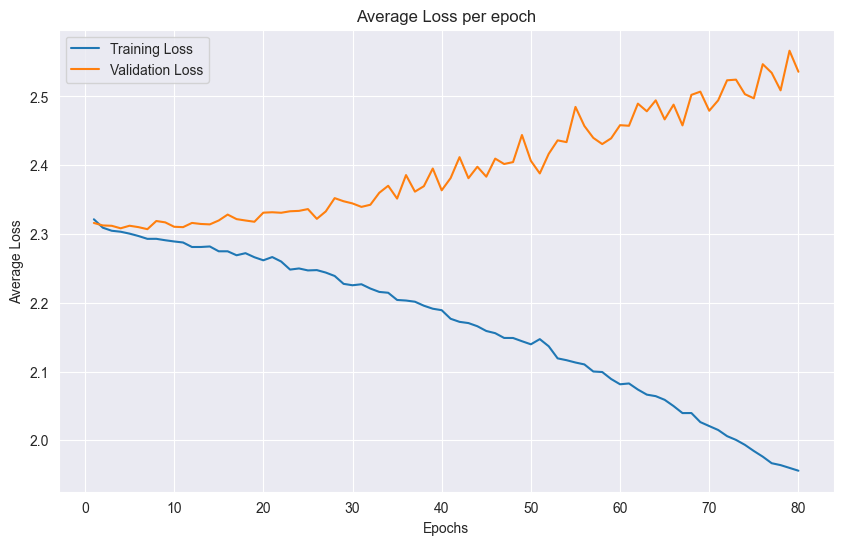

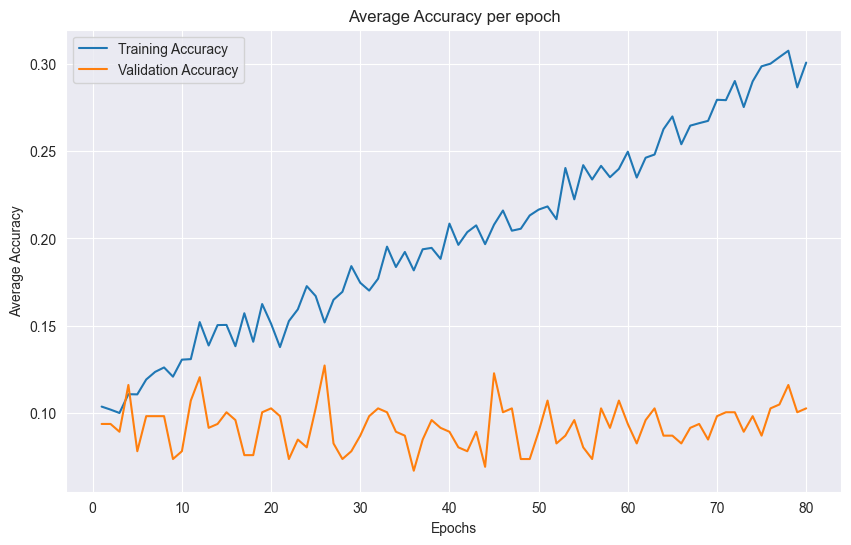

Overall Accuracy: 0.090


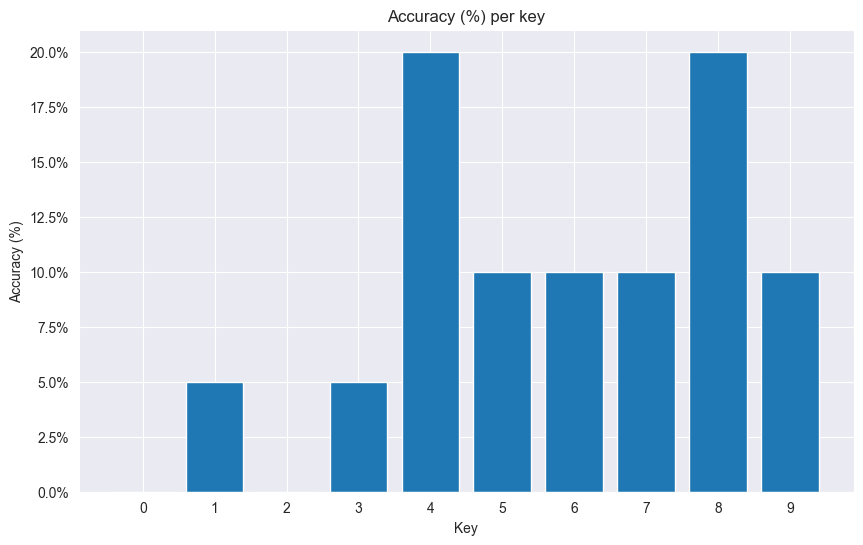

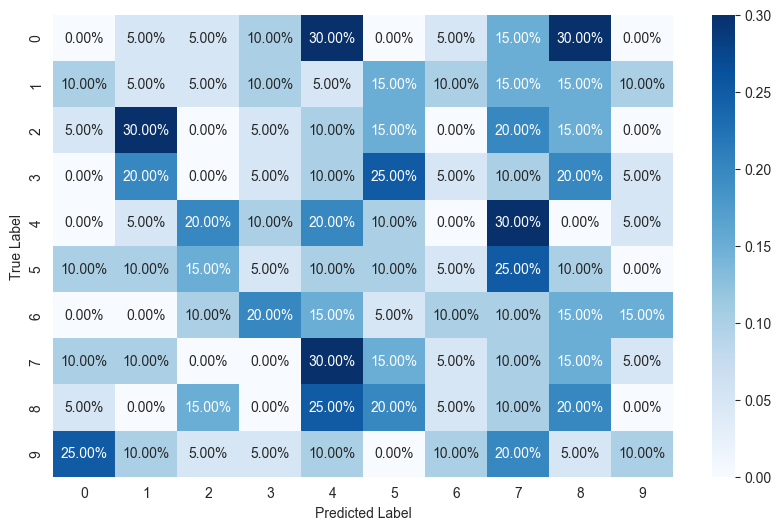

Accuracy for each key: 0: 0.0% 1: 5.0% 2: 0.0% 3: 5.0% 4: 20.0% 5: 10.0% 6: 10.0% 7: 10.0% 8: 20.0% 9: 10.0% 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.05      0.05      0.05        20
           2       0.00      0.00      0.00        20
           3       0.07      0.05      0.06        20
           4       0.12      0.20      0.15        20
           5       0.09      0.10      0.09        20
           6       0.18      0.10      0.13        20
           7       0.06      0.10      0.08        20
           8       0.14      0.20      0.16        20
           9       0.20      0.10      0.13        20

    accuracy                           0.09       200
   macro avg       0.09      0.09      0.09       200
weighted avg       0.09      0.09      0.09       200

                    Model Parameters                    
Layer                    | Parameters
conv1d.weight            : 64 * 64 *

In [10]:
def main():
    # setup parameters and load data
    batch_size = 64
    epochs = 80
    number_of_categories = 10
    
    X_train, X_val, X_test, y_train, y_val, y_test = importData()
    trainDataset = CSIDataset(X_train, y_train)
    valDataset = CSIDataset(X_val, y_val)
    
    trainLoader = DataLoader(trainDataset, shuffle=True, batch_size=batch_size)
    valLoader = DataLoader(valDataset, shuffle=True, batch_size=batch_size)

    model = CNN1D(number_of_categories)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    loss = nn.CrossEntropyLoss()

    # if (os.path.isfile("model.pth")):
    #     model.load_state_dict(torch.load('model.pth'))
    # else:
    #     train_loss_list, train_acc_list, eval_loss_list, eval_acc_list = train_and_eval(model, epochs, optimizer, trainLoader, valLoader, loss, (X_train.shape[0]//batch_size) + 1)
    #     # save the model
    #     torch.save(model.state_dict(), 'model.pth')
    #     plot_loss_accuracy(train_loss_list, train_acc_list, eval_loss_list, eval_acc_list, epochs)
        
    train_loss_list, train_acc_list, eval_loss_list, eval_acc_list = train_and_eval(model, epochs, optimizer, trainLoader, valLoader, loss, (X_train.shape[0]//batch_size) + 1)
    plot_loss_accuracy(train_loss_list, train_acc_list, eval_loss_list, eval_acc_list, epochs)
    torch.save(model.state_dict(), 'model_movement_denoised_butter.pth')
        
    # Simple check with test dataset
    model.eval()
    testDataset = CSIDataset(X_test, y_test)
    testLoader = DataLoader(testDataset, shuffle=True, batch_size=X_test.shape[0])
    test(model, testLoader, X_test.shape[0])
    
    print_model_parameters(model)
    
main()

In [14]:
model = CNN1D(10)
model.load_state_dict(torch.load('model_movement.pth'))
model.eval()

k = 3
extension = ".npy"
for file in os.listdir("../data/real_env"):
    if file.endswith(extension):
        print("========" + file + "========")
        y_batch = torch.tensor([[int(i)] for i in file.split("_")[0]], dtype=torch.float32)
        X_batch = torch.tensor(np.load("../data/real_env/" + file), dtype=torch.float32)
        
        y_batch = y_batch.type(torch.LongTensor).squeeze(1)
        logits = model(X_batch)
        y_pred = F.log_softmax(logits, dim=1)
        
        predicted = np.argmax(y_pred.cpu().detach().numpy(), axis=1)
        print(f"Actual: " + f"{y_batch.tolist()}" + " Predicted: " f"{predicted}")
        values, indices = y_pred.topk(k)
        transposed_indx = torch.transpose(indices, 0, 1)
        print(f"Top k predictions: \n{transposed_indx.tolist()}")

========1436_table.npy========
Actual: [1, 4, 3, 6] Predicted: [1 8 0 8]
Top k predictions: 
[[1, 8, 0, 8], [3, 2, 3, 0], [4, 9, 5, 4]]
========1458_table.npy========
Actual: [1, 4, 5, 8] Predicted: [6 2 6 9]
Top k predictions: 
[[6, 2, 6, 9], [0, 9, 9, 2], [3, 3, 8, 6]]
========1524_table.npy========
Actual: [1, 5, 2, 4] Predicted: [5 2 2 2]
Top k predictions: 
[[5, 2, 2, 2], [9, 6, 7, 8], [8, 3, 8, 1]]
========2289_table.npy========
Actual: [2, 2, 8, 9] Predicted: [4 3 3 1]
Top k predictions: 
[[4, 3, 3, 1], [7, 8, 0, 6], [8, 6, 2, 2]]
========2379_table.npy========
Actual: [2, 3, 7, 9] Predicted: [9 4 9 8]
Top k predictions: 
[[9, 4, 9, 8], [6, 8, 8, 2], [4, 6, 6, 7]]
========3371_table.npy========
Actual: [3, 3, 7, 1] Predicted: [8 8 8 0]
Top k predictions: 
[[8, 8, 8, 0], [0, 1, 5, 8], [7, 0, 0, 9]]
========3917_table.npy========
Actual: [3, 9, 1, 7] Predicted: [5 8 8 1]
Top k predictions: 
[[5, 8, 8, 1], [2, 9, 1, 7], [8, 6, 3, 9]]
========4477_table.npy========
Actual: [4, 4, 7,